<a href="https://colab.research.google.com/github/is0280fp/google_colab/blob/main/1DCNN_9class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle
import tensorflow as tf
import numpy as np

# data
with open("/content/drive/MyDrive/pickle/V_affected.pickle", mode="rb") as f:
   V_affected = pickle.load(f)
f.close()
with open("/content/drive/MyDrive/pickle/V_unaffected.pickle", mode="rb") as f:
   V_unaffected = pickle.load(f)
f.close()

with open("/content/drive/MyDrive/pickle/ML_affected.pickle", mode="rb") as f:
   ML_affected = pickle.load(f)
f.close()
with open("/content/drive/MyDrive/pickle/ML_unaffected.pickle", mode="rb") as f:
   ML_unaffected = pickle.load(f)
f.close()

with open("/content/drive/MyDrive/pickle/AP_affected.pickle", mode="rb") as f:
   AP_affected = pickle.load(f)
f.close()
with open("/content/drive/MyDrive/pickle/AP_unaffected.pickle", mode="rb") as f:
   AP_unaffected = pickle.load(f)
f.close()

with open("/content/drive/MyDrive/pickle/label_fiveclass_witout_both.pickle", mode="rb") as f:
   label = pickle.load(f)
f.close()

In [3]:
# min_max normalizationする場合
from sklearn import preprocessing
mmscaler = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True) # インスタンスの作成、活性化関数でtanhを使うのでfeature_range=(-1,1)

mmscaler.fit(V_affected)
V_affected = mmscaler.transform(V_affected)
V_affected = V_affected.reshape(V_affected.shape[0], V_affected.shape[1], 1)

mmscaler.fit(V_unaffected)
V_unaffected = mmscaler.transform(V_unaffected)
V_unaffected = V_unaffected.reshape(V_unaffected.shape[0], V_unaffected.shape[1], 1)

mmscaler.fit(AP_affected)
AP_affected = mmscaler.transform(AP_affected)
AP_affected = AP_affected.reshape(AP_affected.shape[0], AP_affected.shape[1], 1)

mmscaler.fit(AP_unaffected)
AP_unaffected = mmscaler.transform(AP_unaffected)
AP_unaffected = AP_unaffected.reshape(AP_unaffected.shape[0], AP_unaffected.shape[1], 1)

mmscaler.fit(ML_affected)
ML_affected = mmscaler.transform(ML_affected)
ML_affected = ML_affected.reshape(ML_affected.shape[0], ML_affected.shape[1], 1)

mmscaler.fit(ML_unaffected)
ML_unaffected = mmscaler.transform(ML_unaffected)
ML_unaffected = ML_unaffected.reshape(ML_unaffected.shape[0], ML_unaffected.shape[1], 1)

In [4]:
from keras import optimizers, regularizers
from keras.layers import ELU, Conv2D, MaxPooling2D, LSTM, InputLayer, Dense, Dropout, Activation, Flatten, concatenate, Conv1D, MaxPooling1D, Input, Reshape, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers.advanced_activations import PReLU
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from keras.layers.normalization import BatchNormalization

import seaborn as sns
import matplotlib.pyplot as plt
import time
import math

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
import datetime

NAME = "1DCNN"

# 共通
now = datetime.datetime.now()

# early stopping
early_stopping = EarlyStopping(
                        monitor='val_loss',
                        min_delta=0.0,
                        patience=10,
                )

# checkpointの設定
checkpoint = ModelCheckpoint(
                    filepath="drive/MyDrive/checkpoints/{}_{}".format(NAME, now.strftime('%Y%m%d_%H%M%S')),
                    monitor='val_loss',
                    save_best_only=True,
                    period=1,
                )

# 学習率
def step_decay(epoch):
    x = 5e-6
    if epoch >= 200: x = 5e-7
    if epoch >= 230: x = 5e-8
    return x
lr_decay = LearningRateScheduler(step_decay)

initializer = tf.initializers.he_normal()

# AffectedとUnaffectedをわける * 1DCNN-----------------------------------------------------------------------------------------------------------------------
def build_model():

  GRF_affected_input = Input(shape=(101, 3), name="GRF")

  GRF_affected_features = Conv1D(256, padding = "same", kernel_size=3, strides=1, kernel_initializer=initializer)(GRF_affected_input)
  GRF_affected_features = BatchNormalization()(GRF_affected_features)
  GRF_affected_features = Activation('relu')(GRF_affected_features)

  GRF_affected_features = MaxPooling1D(2)(GRF_affected_features)

  GRF_affected_features = Conv1D(512, padding = "same", kernel_size=3, strides=1, kernel_initializer=initializer)(GRF_affected_features)
  GRF_affected_features = BatchNormalization()(GRF_affected_features)
  GRF_affected_features = Activation('relu')(GRF_affected_features)

  GRF_affected_features = MaxPooling1D(2)(GRF_affected_features)

  GRF_affected_features = Flatten()(GRF_affected_features)

  Dense1 = Dense(512, kernel_initializer=initializer)(GRF_affected_features)
  Dense1 = BatchNormalization()(Dense1)
  Dense1 = Activation('relu')(Dense1)

  Dense2 = Dense(128, kernel_initializer=initializer)(Dense1)
  Dense2 = BatchNormalization()(Dense2)
  Dense2 = Activation('relu')(Dense2)

  Dense3 = Dense(64, kernel_initializer=initializer)(Dense2)
  Dense3 = BatchNormalization()(Dense3)
  Dense3 = Activation('relu')(Dense3)

  output = Dense(9, kernel_initializer=initializer)(Dense3)
  output = BatchNormalization()(output)
  output = Activation('softmax')(output)

  model = Model(
      inputs=[GRF_affected_input],
      outputs=output)

  model.summary()
  return model
#------------------------------------------------------------------------------------------------------------------------------------------------------

# k-fold目のモデルのval_accuracyとval_lossのログ
history = []
# 混合行列のログ
cmx_list = []
# F1などスコアのログ
report_list = []

EPOCHS = 300
# 1~4foldまでは切り捨てあり, batch sizeは常に50 or 100
BATCH_SIZE = 100
i = 0

TRAINS = range(len(label))

train_data_list =[]
val_label_list = []
val_data_list = []
train_label_list = []

for train_index, val_index in skf.split(TRAINS, label):
    # 入力データ整形
    #from IPython.core.debugger import Pdb; Pdb().set_trace()
    train_V_affected = V_affected[train_index]
    train_V_unaffected = V_unaffected[train_index]
    train_AP_affected = AP_affected[train_index]
    train_AP_unaffected = AP_unaffected[train_index]
    train_ML_affected = ML_affected[train_index]
    train_ML_unaffected = ML_unaffected[train_index]

    train_affected = np.concatenate([train_V_affected, train_AP_affected, train_ML_affected], axis=2)
    train_unaffected = np.concatenate([train_V_unaffected, train_AP_unaffected, train_ML_unaffected], axis=2)
    train_data = np.concatenate([train_unaffected, train_affected], axis=0)

    val_V_affected = V_affected[val_index]
    val_V_unaffected = V_unaffected[val_index]
    val_AP_affected = AP_affected[val_index]
    val_AP_unaffected = AP_unaffected[val_index]
    val_ML_affected = ML_affected[val_index]
    val_ML_unaffected = ML_unaffected[val_index]

    val_affected = np.concatenate([val_V_affected, val_AP_affected, val_ML_affected], axis=2)
    val_unaffected = np.concatenate([val_V_unaffected, val_AP_unaffected, val_ML_unaffected], axis=2)
    val_data = np.concatenate([val_unaffected, val_affected], axis=0)

    train_label_unaffected = label[train_index]
    val_label_unaffected = label[val_index]

    # 9クラス分類にラベル振り直し
    train_label_affected = train_label_unaffected + 5
    train_label_affected = np.where(train_label_affected == 5, 0, train_label_affected)
    train_label_affected = np.where(train_label_affected > 5, train_label_affected - 1, train_label_affected)

    val_label_affected = val_label_unaffected + 5
    val_label_affected = np.where(val_label_affected == 5, 0, val_label_affected)
    val_label_affected = np.where(val_label_affected > 5, val_label_affected - 1, val_label_affected)

    train_label = np.concatenate([train_label_unaffected, train_label_affected])
    val_label = np.concatenate([val_label_unaffected, val_label_affected])

    # シャッフル
    p = np.random.permutation(len(train_label))
    train_data = train_data[p]
    train_label = train_label[p]
    # Batch sizeに合わせてデータ切り捨ての場合
    train_data = train_data[:-12]
    train_label = train_label[:-12]

    train_data_list.append(train_data)
    val_label_list.append(val_label)
    val_data_list.append(val_data)
    train_label_list.append(train_label)
    print("train_data", train_data.shape)
    print("val_data", val_data.shape)

train_data (115500, 101, 3)
val_data (28878, 101, 3)
train_data (115500, 101, 3)
val_data (28878, 101, 3)
train_data (115500, 101, 3)
val_data (28878, 101, 3)
train_data (115500, 101, 3)
val_data (28878, 101, 3)
train_data (115500, 101, 3)
val_data (28878, 101, 3)


In [5]:
print(np.array(np.where(train_label == 0)).shape[1]) # HC
print(np.array(np.where(train_label == 1)).shape[1]) # H unaffected
print(np.array(np.where(train_label == 2)).shape[1]) # K unaffected
print(np.array(np.where(train_label == 3)).shape[1]) # A unaffected
print(np.array(np.where(train_label == 4)).shape[1]) # C unaffected
print("")
print(np.array(np.where(train_label == 5)).shape[1]) # H affected
print(np.array(np.where(train_label == 6)).shape[1]) # A affected
print(np.array(np.where(train_label == 7)).shape[1]) # K affected
print(np.array(np.where(train_label == 8)).shape[1]) # C affected

12406
9746
15676
16980
9146

9747
15675
16978
9146


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRF (InputLayer)             [(None, 101, 3)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 101, 256)          2560      
_________________________________________________________________
batch_normalization (BatchNo (None, 101, 256)          1024      
_________________________________________________________________
activation (Activation)      (None, 101, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 512)           393728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 512)           2048  

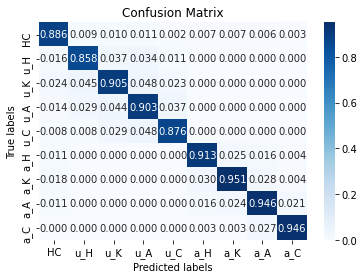

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRF (InputLayer)             [(None, 101, 3)]          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 101, 256)          2560      
_________________________________________________________________
batch_normalization_6 (Batch (None, 101, 256)          1024      
_________________________________________________________________
activation_6 (Activation)    (None, 101, 256)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 50, 512)           393728    
_________________________________________________________________
batch_normalization_7 (Batch (None, 50, 512)           2048

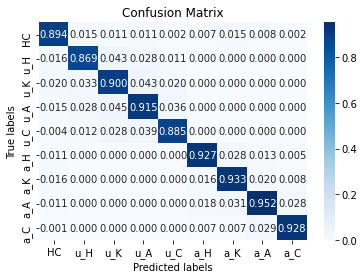

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRF (InputLayer)             [(None, 101, 3)]          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 101, 256)          2560      
_________________________________________________________________
batch_normalization_12 (Batc (None, 101, 256)          1024      
_________________________________________________________________
activation_12 (Activation)   (None, 101, 256)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 50, 256)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 50, 512)           393728    
_________________________________________________________________
batch_normalization_13 (Batc (None, 50, 512)           2048

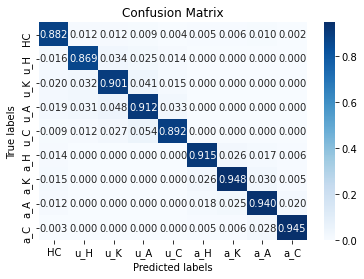

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRF (InputLayer)             [(None, 101, 3)]          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 101, 256)          2560      
_________________________________________________________________
batch_normalization_18 (Batc (None, 101, 256)          1024      
_________________________________________________________________
activation_18 (Activation)   (None, 101, 256)          0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 50, 256)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 50, 512)           393728    
_________________________________________________________________
batch_normalization_19 (Batc (None, 50, 512)           2048

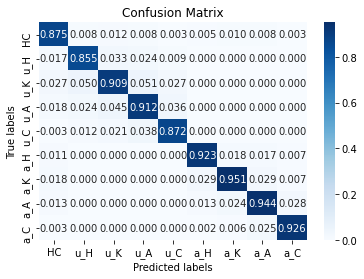

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRF (InputLayer)             [(None, 101, 3)]          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 101, 256)          2560      
_________________________________________________________________
batch_normalization_24 (Batc (None, 101, 256)          1024      
_________________________________________________________________
activation_24 (Activation)   (None, 101, 256)          0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 50, 256)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 50, 512)           393728    
_________________________________________________________________
batch_normalization_25 (Batc (None, 50, 512)           2048

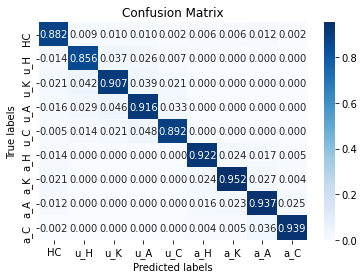

In [6]:
for i in range(0, 5):
  model = build_model()
  model.compile(loss='sparse_categorical_crossentropy', 
            optimizer= optimizers.Adam(lr=0.002, beta_1= 0.9, beta_2= 0.999),
            metrics=['accuracy']
            )
  model.fit(
      x={"GRF": train_data_list[i]}, 
      y=train_label_list[i], 
      batch_size=BATCH_SIZE, 
      epochs=EPOCHS, 
      verbose=1,
      validation_data=(
          {"GRF": val_data_list[i]}, 
            val_label_list[i]),
      callbacks=[early_stopping, lr_decay, checkpoint]
      )
  print("results per k-fold")
  history.append(model.evaluate(x={"GRF": val_data_list[i]}, y=val_label_list[i], batch_size=BATCH_SIZE, verbose=1))
  # save weights
  now = datetime.datetime.now()
  file_name = "drive/MyDrive/temp/{}fold_{}_{}".format(i, NAME, now.strftime('%Y%m%d_%H%M%S'))
  model.save(file_name+'.h5')

  # 混合行列
  predict_prob = model.predict({"GRF": val_data_list[i]})
  predict_classes=np.argmax(predict_prob,axis=1)
  true_classes = val_label_list[i]

  cmx = confusion_matrix(true_classes, predict_classes)
  cmx_list.append(cmx)
  print(cmx)

  index1 = ["HC", "u_H", "u_K", "u_A", "u_C", "a_H", "a_K", "a_A", "a_C"]

  report = classification_report(true_classes, predict_classes, target_names=index1)
  report_list.append(report)
  print(report)

  cmx_data = []
  for i in range(len(cmx)):
    for j in range(len(cmx)): 
      cmx_data.append((cmx[j, i] / np.sum(cmx[i])))

  cmx_data = np.array(cmx_data).reshape(9, 9)

  ax= plt.subplot()
  sns.heatmap(cmx_data, annot=True, ax = ax, fmt="1.3f", cmap="Blues")
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix') 
  ax.xaxis.set_ticklabels(index1) 
  ax.yaxis.set_ticklabels(index1)
  plt.show()

  i = i + 1

with open("/content/drive/MyDrive/temp/cmx_{}_{}.pickle".format(NAME, now.strftime('%Y%m%d_%H%M%S')), mode="wb") as f:
   pickle.dump(cmx_list, f)
f.close()

with open("/content/drive/MyDrive/temp/classification_report_{}_{}.pickle".format(NAME, now.strftime('%Y%m%d_%H%M%S')), mode="wb") as f:
   pickle.dump(report_list, f)
f.close()